<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/ot_2d_interpolate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
Build intuition about optimal transport with toy problems.

In [2]:
!pip install pot
import ot 

     |████████████████████████████████| 430kB 4.8MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def doplt(arr2d):
  plt.imshow(arr2d,cmap='gray')

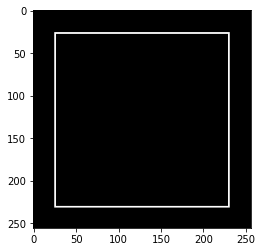

In [4]:
def make_solid_square(N,rad):
  sq = np.zeros((N,N))
  mid=N//2
  for i in range(N):
    if (mid-rad < i and i <= mid+rad):
      for j in range(N):
        if mid-rad <= j and j < mid+rad:
          sq[i,j]=1
  return(sq)

def make_border_square(N,rad,thickness):
  assert thickness%2 == 0, 'thickness must be even'
  assert N%2 == 0, 'N must be even'
  sq_out = make_solid_square(N,rad+thickness//2)
  sq_in = make_solid_square(N,rad-thickness//2)
  return(np.logical_and(sq_out.astype(np.bool),~sq_in.astype(np.bool)))

N=256
sq = make_border_square(N=N,rad=N//2.5,thickness=2)
doplt(sq)


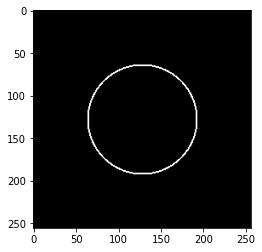

In [5]:
def make_solid_circle(N,rad):
  x = np.arange(-N//2,N//2)
  xv, yv = np.meshgrid(x, x, sparse=False, indexing='ij')
  r2 = xv**2+yv**2
  circle = r2 < rad**2
  return(circle)


def make_border_circle(N,rad,thickness):
  circle_in = make_solid_circle(N,rad=rad-thickness//2)
  circle_out = make_solid_circle(N,rad=rad+thickness//2)
  return(np.logical_and(circle_out.astype(np.bool),~circle_in.astype(np.bool)))

N=256
circle = make_border_circle(N=N,rad=N//4,thickness=2)
doplt(circle)

## Cost
The cost is just the euclidean distance from one (grid) point (in one shape) to the other (in the other shape).

### Coordinates

In [6]:
N=256
x = np.arange(-N//2,N//2)
xv, yv = np.meshgrid(x, x, sparse=False, indexing='ij')



In [7]:
circle = make_border_circle(N=N,rad=N//4,thickness=2)
circle_coords = np.zeros((circle.sum(),2))
circle_coords[:,0], circle_coords[:,1] = xv[circle], yv[circle]

In [8]:
sq = make_border_square(N=N,rad=N//2.5,thickness=2)
sq_coords = np.zeros((sq.sum(),2))
sq_coords[:,0], sq_coords[:,1] = xv[sq], yv[sq]
n_sq, n_c = sq_coords.shape[0], circle_coords.shape[0]
n_sq, n_c

(1632, 788)

In [9]:
C = np.zeros((n_sq, n_c))
for i in range(n_sq):
  for j in range(n_c):
    C[i,j] = np.sqrt(((sq_coords[i]-circle_coords[j])**2).sum())
np.allclose(C,ot.dist(sq_coords,circle_coords,metric='euclidean'))



True

# Optimal Transport Plan

In [10]:
C/=C.max()
ot_plan = ot.sinkhorn(np.ones(n_sq),np.ones(n_c),C,reg=0.01)

/usr/local/lib/python3.6/dist-packages/ot/bregman.py:364: RuntimeWarning: overflow encountered in true_divide
  u = 1. / np.dot(Kp, v)


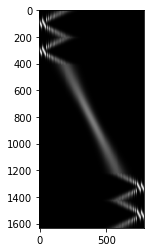

In [11]:
doplt(ot_plan)

# Interpolate
The optimal transport plan gives a direction to travel in, in terms of the vector from the initial point in the column to the linear combination of points in the row.

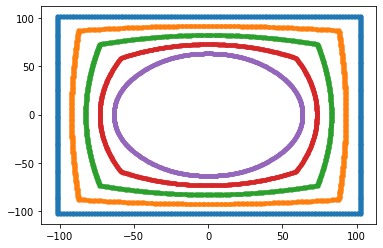

In [12]:
for t in np.linspace(0,1,5):
  flex_t = (1-t)*sq_coords + t*ot_plan.dot(circle_coords) 
  plt.scatter(flex_t[:,0],flex_t[:,1],marker='.')

So here we see how a shapes, represented by a point cloud, can be interconverted to one another.

This was done for a binary 2D scalar map, but it immediately extendable to real values (ie where the pixels in the 2D image have an intensity). This takes us a step closer to interpolating 3D volumes.

# Simple point cloud
The regularization term makes the points cluster closer together (resemble the initial shape more)

In [525]:
#g1 = np.array([[0,2],[1,1],[2,0]])
g1 = np.array([[1-.1,1],[1,1],[1,1-.1]])
#g1 = np.array([[1,1],[1,1],[1,1]])

g2 = np.array([[-2,0],[-1,-1],[0,-2]])
n = 3
C = ot.dist(g1,g2,metric='euclidean')
C/=C.max()
ones = np.ones(n)
ot_plan = ot.sinkhorn(ones,ones,C,reg=0.0001,method='sinkhorn_stabilized') # important to use stabilized for reg less than ~0.01
#ot_plan = ot.emd(ones,ones,C) # important to use stabilized for reg less than ~0.01

ot_plan


array([[9.99610743e-01, 3.89256520e-04, 2.46138115e-89],
       [1.62740341e-31, 1.00000000e+00, 1.62740341e-31],
       [2.46138115e-89, 3.89256520e-04, 9.99610743e-01]])

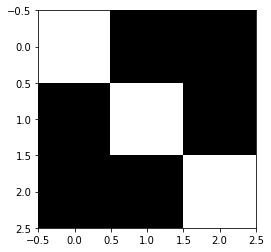

In [526]:
doplt(ot_plan)

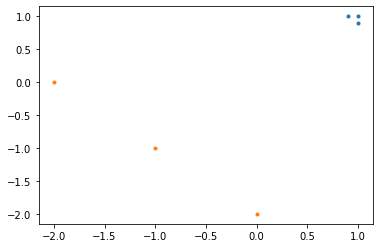

In [527]:
plt.scatter(g1[:,0],g1[:,1],marker='.')
plt.scatter(g2[:,0],g2[:,1],marker='.')

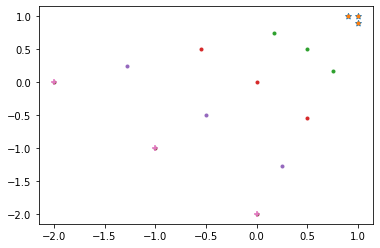

In [531]:
plt.scatter(g1[:,0],g1[:,1],marker='*')
for t in np.linspace(0,1,5):
  flex_t = (1-t)*g1 + t*ot_plan.dot(g2)
  plt.scatter(flex_t[:,0],flex_t[:,1],marker='.')
plt.scatter(g2[:,0],g2[:,1],marker='+')

# Weighted point cloud

Each $ij$ of the transport plan $T$ represents how the point $(x_i,y_i)$, density weighted by $a_i$ is transported to $(x_j,y_j)$. Thus, we can get the interpolation by looking at all the non-zero entries $T_{ij}$ of the transport plan, and then computing where they are on the vector $[x_j-x_i,y_j-y_i]$, and weight this contribution by $T_{ij}$.

In [620]:
#g1 = np.array([[0,2],[1,1],[2,0]])
g1 = np.array([[1-.1,1],[1,1],[1,1-.1]])
#g1 = np.array([[1,1],[1,1],[1,1]])

g2 = np.array([[-2,0],[-1,-1],[0,-2]])
n = 3
C = ot.dist(g1,g2,metric='euclidean')
C/=C.max()
ones = np.ones(n)
a,b = np.array([1,2,1]), np.array([2,1,1])
#ot_plan = ot.sinkhorn(ones,ones,C,reg=0.0001,method='sinkhorn_stabilized') # important to use stabilized for reg less than ~0.01
ot_plan = ot.emd(a,b,C) # important to use stabilized for reg less than ~0.01

ot_plan


array([[1., 0., 0.],
       [1., 1., 0.],
       [0., 0., 1.]])

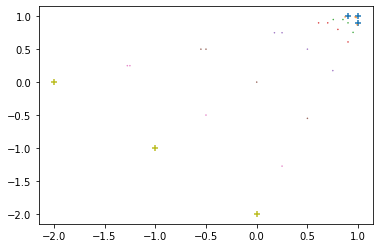

In [621]:
flex_t = np.zeros(((ot_plan>0).sum().astype(np.int32),2))
vals = ot_plan[ot_plan>0]
  
plt.scatter(g1[:,0],g1[:,1],marker='+')
for t in [.01,.05,.1,.25,.5,.75,1]:
  row=0
  for i in range(g1.shape[0]):
    for j in range(g2.shape[0]):
      if ot_plan[i,j] > 0:
        flex_t[row,:] = (1-t)*g1[i]+t*g2[j]
        row+=1
  plt.scatter(flex_t[:,0],flex_t[:,1],marker='.',s=vals)
plt.scatter(g2[:,0],g2[:,1],marker='+')

We see that the three initial dots break up into four (because the density weights are [1,2,1], which represents four), and then reform into the final three points (with density weights [2,1,1])

## Gaussian point cloud

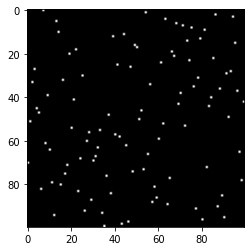

In [369]:
cov = np.eye(2)
n=100
mu=10
g1 = np.random.multivariate_normal(mean=[mu,mu], cov=cov, size=n)
g2 = np.random.multivariate_normal(mean=[-mu,-mu], cov=cov, size=n)
C = ot.dist(g1,g2,metric='euclidean')
C/=C.max()
ones = np.ones(n)
#ot_plan = ot.sinkhorn(ones,ones,C,reg=0.001,method='sinkhorn_stabilized')
ot_plan = ot.emd(ones,ones,C)
doplt(ot_plan)

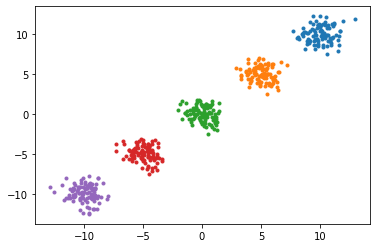

In [396]:
for t in np.linspace(0,1,5):
  flex_t = (1-t)*g1 + t*ot_plan.dot(g2) 
  plt.scatter(flex_t[:,0],flex_t[:,1],marker='.')

True

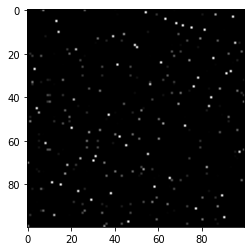

In [386]:
ot_plan_sink = ot.sinkhorn(ones,ones,C,reg=1e-7,method='sinkhorn_epsilon_scaling',numItermax=10000)
doplt(ot_plan_sink)
np.allclose(ot_plan_sink.sum(0),np.ones(n))

In [395]:
np.isclose(ot_plan_sink[ot_plan>0],ot_plan[ot_plan>0],atol=0.05).mean()

0.33

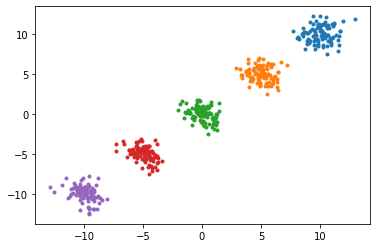

In [397]:
for t in np.linspace(0,1,5):
  flex_t = (1-t)*g1 + t*ot_plan_sink.dot(g2) 
  plt.scatter(flex_t[:,0],flex_t[:,1],marker='.')

In [ ]:
# ot_plan_sink_round = np.zeros_like(ot_plan_sink)
# row_idx = np.argmax(ot_plan_sink,0)
# for c in range(n):
#   ot_plan_sink_round[row_idx[c],c] = 1
# doplt(ot_plan_sink_round)


# Interpolating 2D scalar density maps
Will use 2D Gaussians. Use np.histogram2d to sample on grid. Can verify/compare with original point cloud.

## shapes/images on 2D grid

In [13]:
from scipy.stats import multivariate_normal


(None, 100.0)

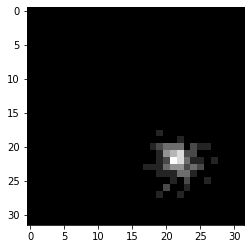

In [809]:
def sample_gauss2d_grid(mean=[0,0],cov=np.eye(2),size=10**4,std=1,bins=32,window=5):
  g = np.random.multivariate_normal(mean=mean, cov=cov, size=size)
  H, xedges, yedges = np.histogram2d(g[:,0], g[:,1], bins=bins, range=window*np.array([[-1,1],[-1,1]]))
  return(H, xedges, yedges)
H1, xedges1, yedges1 = sample_gauss2d_grid(mean=np.array([10,10]),cov=10*np.eye(2),size=100,bins=32,window=25)
doplt(H1), H1.sum()

(None, 100.0)

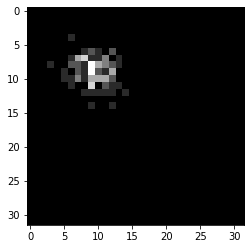

In [808]:
H2, xedges2, yedges2 = sample_gauss2d_grid(mean=np.array([-10,-10]),cov=10*np.eye(2),size=100,bins=32,window=25)
doplt(H2), H2.sum()

The histogramming sometimes drops points if it goes outside the window (edges). Repeat until the sum is the same as the size. TODO: clip

In [810]:
xv, yv = np.meshgrid(xedges1[:-1], xedges1[:-1], sparse=False, indexing='ij')
coords = np.zeros((xv.size,2)) 
coords[:,0], coords[:,1]=xv.flatten(), yv.flatten()
a_coords = coords[H1.flatten()>0]
b_coords = coords[H2.flatten()>0]
C = ot.dist(a_coords,b_coords,metric='euclidean')
C/=C.max()
a = H1[H1>0]
b = H2[H2>0]


In [811]:
a_coords.shape, b_coords.shape, H1.flatten().shape

((46, 2), (49, 2), (1024,))

In [812]:
(H1).sum(), (H2).sum()

(100.0, 100.0)

In [813]:
a.shape,b.shape

((46,), (49,))

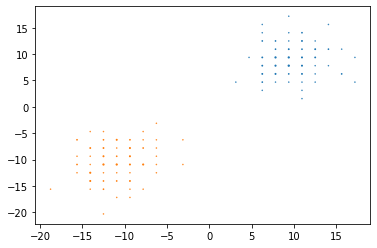

In [814]:
plt.scatter(a_coords[:,0],a_coords[:,1],marker='.',s=a)
plt.scatter(b_coords[:,0],b_coords[:,1],marker='.',s=b)


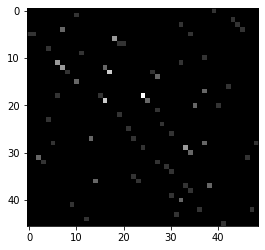

In [815]:
ot_plan = ot.emd(a,b,C)
doplt(ot_plan)

In [816]:
import pandas as pd
pd.Series(ot_plan.flatten()).value_counts()

0.0    2186
1.0      47
2.0      14
3.0       4
4.0       2
5.0       1
dtype: int64

In [817]:
np.allclose(a,ot_plan.sum(1)), np.allclose(b,ot_plan.sum(0))

(True, True)

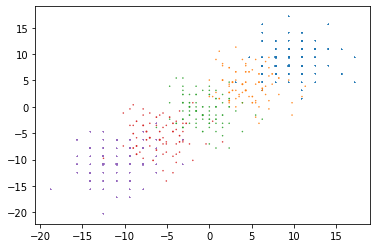

In [818]:
flex_t = np.zeros(((ot_plan>0).sum().astype(np.int32),2))
vals = ot_plan[ot_plan>0]

plt.scatter(a_coords[:,0],a_coords[:,1],marker='+',s=a)
for t in [.25,0.5,.75]:
  row=0
  for i in range(a_coords.shape[0]):
    for j in range(b_coords.shape[0]):
      if ot_plan[i,j] > 0:
        flex_t[row,:] = (1-t)*a_coords[i]+t*b_coords[j]
        row+=1
  plt.scatter(flex_t[:,0],flex_t[:,1],marker='.',s=vals)
plt.scatter(b_coords[:,0],b_coords[:,1],marker='+',s=b)

The shape looks squeezed in the direction of travel

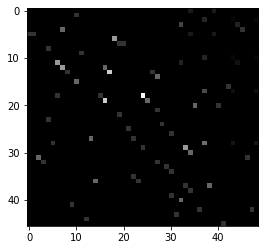

In [867]:
ot_plan_sink = ot.sinkhorn(a,b,C,reg=1e-7,method='sinkhorn_epsilon_scaling')
doplt(ot_plan_sink)


In [868]:
np.isclose(ot_plan_sink[ot_plan>0],ot_plan[ot_plan>0],atol=0.05).mean() # the significance of the atol is relative to the row/col sums are

0.8529411764705882

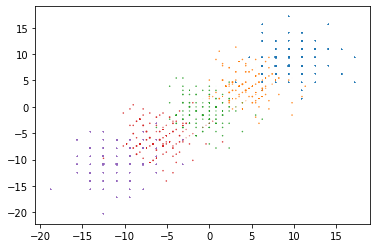

In [869]:
flex_t = np.zeros(((ot_plan_sink>0).sum().astype(np.int32),2))
vals = ot_plan_sink[ot_plan_sink>0]

plt.scatter(a_coords[:,0],a_coords[:,1],marker='+',s=a)
for t in [.25,0.5,.75]:
  row=0
  for i in range(a_coords.shape[0]):
    for j in range(b_coords.shape[0]):
      if ot_plan_sink[i,j] > 0:
        flex_t[row,:] = (1-t)*a_coords[i]+t*b_coords[j]
        row+=1
  plt.scatter(flex_t[:,0],flex_t[:,1],marker='.',s=vals)
plt.scatter(b_coords[:,0],b_coords[:,1],marker='+',s=b)

Compare the `ot.emd` solution with the regularized solution. Is there a significant difference?

The points can be histogramed / sampled on a grid to have a discrete interpolation

## regularization

0.029411764705882353

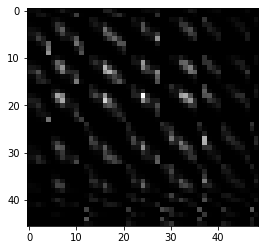

In [876]:
ot_plan_sink = ot.sinkhorn(a,b,C,reg=1e-3,method='sinkhorn_epsilon_scaling')
doplt(ot_plan_sink)
np.isclose(ot_plan_sink[ot_plan>0],ot_plan[ot_plan>0],atol=0.5).mean() # the significance of the atol is relative to the row/col sums are

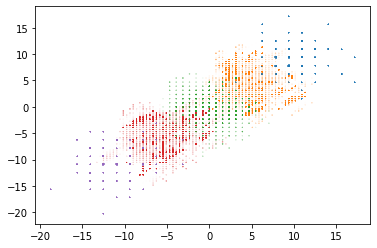

In [877]:
flex_t = np.zeros(((ot_plan_sink>0).sum().astype(np.int32),2))
vals = ot_plan_sink[ot_plan_sink>0]

plt.scatter(a_coords[:,0],a_coords[:,1],marker='+',s=a)
for t in [.25,0.5,.75]:
  row=0
  for i in range(a_coords.shape[0]):
    for j in range(b_coords.shape[0]):
      if ot_plan_sink[i,j] > 0:
        flex_t[row,:] = (1-t)*a_coords[i]+t*b_coords[j]
        row+=1
  plt.scatter(flex_t[:,0],flex_t[:,1],marker='.',s=vals)
plt.scatter(b_coords[:,0],b_coords[:,1],marker='+',s=b)

More regularization makes the distributions shape less diverse (perhaps more like the start/finish shape?).